# Exploration 7
# Movie Review Sentiment Analysis


## |프로젝트: 네이버 영화리뷰 감성분석 도전하기
### |프로젝트 학습 과정

1. 데이터 준비와 확인
2. 데이터로더 구성
3. 모델구성을 위한 데이터 분석 및 가공
    - 데이터셋 내 문장 길이 분포
    - 적절한 최대 문장 길이 지정
    - keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
4. 모델구성 및 validation set 구성
5. 모델 훈련 개시
6. Loss, Accuracy 그래프 시각화
7. 학습된 Embedding 레이어 분석
8. 한국어 Word2Vec 임베딩 활용하여 성능개선


한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.
- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

# 1. 데이터 준비와 확인

In [12]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from IPython.core import display as ICD

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Naver Sentiment Movie Corpus(NSMC)

This is a movie review dataset in the Korean language. Reviews were scraped from Naver Movies.

The dataset construction is based on the method noted in Large movie review dataset from Maas et al., 2011.

### Data description

- Each file is consisted of three columns: id, document, label
    - id: The review id, provieded by Naver
    - document: The actual review
    - label: The sentiment class of the review. (0: negative, 1: positive)
    - Columns are delimited with tabs (i.e., .tsv format; but the file extension is .txt for easy access for novices)

- 200K reviews in total
    - ratings.txt: All 200K reviews
    - ratings_test.txt: 50K reviews held out for testing
    - ratings_train.txt: 150K reviews for training
    
### Characteristics
- All reviews are shorter than 140 characters
- Each sentiment class is sampled equally (i.e., random guess yields 50% accuracy)
    - 100K negative reviews (originally reviews of ratings 1-4)
    - 100K positive reviews (originally reviews of ratings 9-10)
    - Neutral reviews (originally reviews of ratings 5-8) are excluded

# 2. 데이터로더 구성

IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 제공해줌. 지금 다룰 **nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있음**

- 이 데이터를 읽어서 imdb.data_loader()와 동일하게 동작하는 본인의 data_loader 만들기!

### data_loader 만드는 법

1. 데이터의 중복 제거
2. 특수문자 제거
3. NaN 결측치 제거
4. 한국어 토크나이저로 토큰화
5. 불용어(Stopwords) 제거
6. 사전 word_to_index 구성
7. 텍스트 스트링을 사전 인덱스 스트링으로 변환
8. x_train, y_train, x_test, y_test, word_to_index 리턴

### 데이터 중복값 조회

In [13]:
print(len(train_data)-len(train_data['document'].value_counts()), "개")
print(len(test_data)-len(test_data['document'].value_counts()), "개")

3818 개
843 개


In [14]:
print(train_data['document'].value_counts())
print(test_data['document'].value_counts())

굿                                                                                                                                            181
good                                                                                                                                          92
최고                                                                                                                                            85
쓰레기                                                                                                                                           79
별로                                                                                                                                            66
                                                                                                                                            ... 
무슨말이 필요한가..... 이건 리메이크작이 제아무리 길고 날뛰어도 원작 못따라올듯... 원작이 너무 완벽해 마지막 너무 슬프네여 ㅠ                                                        

In [15]:
# mecab 기반 한국어 형태소 분석기
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):

    # 1. 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 2. 특수문자 제외
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    # 3. 결측값 처리
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any') 
    
    # 4. 한국어 토크나이저로 토큰화/ 5. 불용어 제거
    x_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    # 4, 5
    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    # 6. 사전 word_to_index 구성
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 7. 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
    
    # 8. x_train, y_train, x_test, y_test, word_to_index 리턴
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 
print("train 길이: {},  test 길이: {} ".format(len(x_train),len(x_test)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


train 길이: 146182,  test 길이: 49157 


#### word to index

In [16]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '영화': 4,
 '다': 5,
 '고': 6,
 '하': 7,
 '을': 8,
 '보': 9,
 '게': 10,
 '지': 11,
 '있': 12,
 '없': 13,
 '좋': 14,
 '나': 15,
 '었': 16,
 '만': 17,
 '는데': 18,
 '너무': 19,
 '봤': 20,
 '적': 21,
 '안': 22,
 '정말': 23,
 '로': 24,
 '것': 25,
 '음': 26,
 '아': 27,
 '네요': 28,
 '어': 29,
 '재밌': 30,
 '지만': 31,
 '같': 32,
 '진짜': 33,
 '에서': 34,
 '했': 35,
 '기': 36,
 '네': 37,
 '않': 38,
 '점': 39,
 '거': 40,
 '았': 41,
 '수': 42,
 '되': 43,
 '면': 44,
 'ㅋㅋ': 45,
 '인': 46,
 '말': 47,
 '연기': 48,
 '주': 49,
 '최고': 50,
 '내': 51,
 '평점': 52,
 '이런': 53,
 '던': 54,
 '어요': 55,
 '할': 56,
 '왜': 57,
 '겠': 58,
 '스토리': 59,
 '해': 60,
 'ㅋㅋㅋ': 61,
 '습니다': 62,
 '듯': 63,
 '아니': 64,
 '드라마': 65,
 '생각': 66,
 '더': 67,
 '그': 68,
 '싶': 69,
 '사람': 70,
 '때': 71,
 '감동': 72,
 '배우': 73,
 '함': 74,
 '본': 75,
 '까지': 76,
 '뭐': 77,
 '알': 78,
 '만들': 79,
 '내용': 80,
 '볼': 81,
 '보다': 82,
 '감독': 83,
 '라': 84,
 '재미': 85,
 '그냥': 86,
 '시간': 87,
 '지루': 88,
 '중': 89,
 '재미있': 90,
 '였': 91,
 '잼': 92,
 '년': 93,
 '사랑': 94,
 

In [17]:
# '짜증'이란 단어도 들어가 있을까?
word_to_index['짜증']

214

#### index to word

In [18]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [19]:
for value in index_to_word.values():
    print(value, end=' ')

<PAD> <BOS> <UNK> <UNUSED> 영화 다 고 하 을 보 게 지 있 없 좋 나 었 만 는데 너무 봤 적 안 정말 로 것 음 아 네요 어 재밌 지만 같 진짜 에서 했 기 네 않 점 거 았 수 되 면 ㅋㅋ 인 말 연기 주 최고 내 평점 이런 던 어요 할 왜 겠 스토리 해 ㅋㅋㅋ 습니다 듯 아니 드라마 생각 더 그 싶 사람 때 감동 배우 함 본 까지 뭐 알 만들 내용 볼 보다 감독 라 재미 그냥 시간 지루 중 재미있 였 잼 년 사랑 못 재미없 냐 쓰레기 서 라고 니 면서 다시 번 나오 하나 작품 야 이거 줄 해서 남 마지막 끝 정도 이건 액션 개 임 건 기대 다는 입니다 라는 완전 참 많 ㅋ 처음 장면 다가 아깝 으면 모르 지금 이렇게 분 돈 이게 ㅠㅠ 성 느낌 이야기 일 최악 된 시 봐도 님 어서 애 편 다고 넘 인데 이해 전 별로 걸 그리고 명작 난 또 역시 여자 한국 이상 는지 많이 에게 부터 주인공 받 합니다 대 두 우리 만든 길 엔 살 괜찮 요 기억 ㅡㅡ 한다 연출 ㅎㅎ 때문 저 이나 재 꼭 며 현실 랑 긴 무슨 내내 죽 결말 남자 전개 마음 세요 소재 속 아서 공포 데 다른 인생 씨 짜증 뿐 짱 은데 아요 아이 필요 유치 가장 음악 일본 낮 오 반전 수준 웃 다니 매력 별 인지 맞 가슴 없이 원작 인간 굿 높 ㄷ 밋 만드 눈물 급 보여 준 찍 인가 노 코미디 신 용 모든 마 화 추천 아직 아닌 처럼 쓰 눈 자체 울 몰입 대박 란 스럽 몇 을까 실망 대한 는다 여 그런 죠 솔직히 캐릭터 아주 모두 전혀 가족 여운 건지 연기력 될 다면 뭔가 그래도 후 나라 시리즈 ㅎ 근데 표현 모습 계속 작 공감 먹 제목 비 이랑 극장 치 이걸 부분 그렇 대사 바 대단 어디 개봉 진 아쉽 된다 기분 작가 진심 구 해도 놓 타임 봐야 제 보이 웃기 막장 삶 물 친구 잔잔 이제 조금 억지 가지 ㅠ 영상 찾 라도 씬 딱 요즘 같이 스릴러 믿 싫 나왔 아까운 중간 긴장감 어떻게 개인 제대로 점수 부족 이유 노래 만큼 ㅜㅜ 라면 시작 잇 구나 한테 특히 려고 날 제일 

In [20]:
# 문장 1개를 활용할 딕셔너리와 함께 주면,
# 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에
# 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델구성을 위한 데이터 분석 및 가공

### 1) 데이터셋 내 문장 길이 분포

In [21]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[27, 67, 895, 33, 214, 15, 28, 699]
라벨:  0
1번째 리뷰 문장 길이:  8
2번째 리뷰 문장 길이:  13


In [22]:
# x_train과 x_test를 합치기
total_data_text = list(x_train) + list(x_test)

# 텍스트 데이터의 문장의 길이를 재주는 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장 길이 평균:', np.mean(num_tokens))
print('문장 길이 최대:', np.max(num_tokens))
print('문장 길이 표준편차:', np.std(num_tokens))
print('문장 길이 중앙값:', np.median(num_tokens))

문장 길이 평균: 13.718233430088207
문장 길이 최대: 83
문장 길이 표준편차: 11.469848902034261
문장 길이 중앙값: 10.0


리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.718233430088207


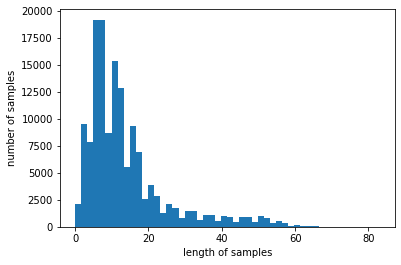

In [23]:
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 2) 적절한 최대 문장 길이 지정

In [24]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  36
전체 문장의 0.9340019146202243%가 maxlen 설정값 이내에 포함됩니다. 


#### 적절한 문장의 최대 길이를 지정해야 한다.
- 대부분 0~20개에 몰려 있다.
- 최대 길이를 평균 + 2 * 표준편차로 한다면, 36이 나온다.
- 분포의 90% 이상을 포함할 수 있는 길이인 40을 임의로 지정한다.

In [25]:
max_len = 40
max_len

40

### 3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

[pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) 에 대해 알아보자.

- padding을 추가해줘야 하는 이유는 아까 위에서 확인했다시피 문장마다 최대 길이(토큰의 개수)가 다르기 때문에 이를 동일하게 맞춰줘야 한다. 그래서 임의의 값을 넣어서 길이를 맞춰주는 것이 padding 작업이다.

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, 
                        maxlen = max_len,
                        value=word_to_index["<PAD>"],
                        padding='pre')

x_test = pad_sequences(x_test, 
                       maxlen = max_len,
                       value=word_to_index["<PAD>"],
                       padding='pre')

In [27]:
print("x_train 크기:", x_train.shape,)
print("x_test 크기:", x_test.shape)

x_train 크기: (146182, 40)
x_test 크기: (49157, 40)


최대 길이로 설정한 40에 맞게 shape이 맞춰졌다.

# 4. 모델 구성

### 하이퍼파라미터 정의

입력층과 임베딩 층을 정의하기

In [49]:
total_cnt = len(word_to_index)  # 어휘 사전의 크기입니다
vocab_size = total_cnt

print(total_cnt, '개')

10000 개


아까 num_words를 10000로 설정해두었기 때문에 어휘 사전(📔)의 크기가 10000으로 조회가 되었습니다.

In [29]:
word_vector_dim = 200
print(word_vector_dim, '개')

200 개


워드 벡터의 차원수 (변경 가능한 하이퍼파라미터)   
단어 하나를 표현하는 임베딩 벡터의 차원수

## Setup

In [84]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.layers import Dense, SimpleRNN, Activation

### RNN

In [118]:
model = keras.Sequential()

model.add(layers.Embedding(total_cnt, word_vector_dim, input_shape=(None,)))

model.add(layers.GRU(256, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
gru_5 (GRU)                  (None, None, 256)         351744    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total params: 2,402,314
Trainable params: 2,402,314
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
229/229 [==============================] - 22s 86ms/step - loss: 2.0687 - accuracy: 0.4519 - val_loss: 1.0903 - val_accuracy: 0.0251
Epoch 2/5
229/229 [==============================] - 19s 83ms/step - loss: 0.7134 - accuracy: 0.0734 - val_loss: 0.4841 - val_accuracy: 0.0994
Epoch 3/5
229/229 [==============================] - 19s 83ms/step - loss: 0.4257 - accuracy: 0.1237 - val_loss: 0.4896 - val_accuracy: 0.1744
Epoch 4/5
229/229 [==============================] - 19s 84ms/step - loss: 1.5369 - accuracy: 0.0639 - val_loss: 1.2125 - val_accuracy: 0.0049
Epoch 5/5
229/229 [==============================] - 19s 83ms/step - loss: 1.7712 - accuracy: 0.0082 - val_loss: 2.6340 - val_accuracy: 2.3891e-04


### LSTM

In [79]:
model = keras.Sequential()

model.add(layers.Embedding(total_cnt, word_vector_dim, input_shape=(None,)))
model.add(layers.LSTM(128))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
229/229 [==============================] - 12s 42ms/step - loss: 0.5079 - accuracy: 0.7378 - val_loss: 0.3539 - val_accuracy: 0.8423
Epoch 2/5
229/229 [==============================] - 9s 40ms/step - loss: 0.3283 - accuracy: 0.8583 - val_loss: 0.3458 - val_accuracy: 0.8466
Epoch 3/5
229/229 [==============================] - 9s 40ms/step - loss: 0.2956 - accuracy: 0.8725 - val_loss: 0.3431 - val_accuracy: 0.8502
Epoch 4/5
229/229 [==============================] - 9s 40ms/step - loss: 0.2584 - accuracy: 0.8900 - val_loss: 0.3516 - val_accuracy: 0.8505
Epoch 5/5
229/229 [==============================] - 9s 40ms/step - loss: 0.2339 - accuracy: 0.9009 - val_loss: 0.3642 - val_accuracy: 0.8494


### 1D CNN

In [57]:
dropout_prob = (0.5, 0.8)

model_input = Input(shape = (max_len,))
z = Embedding(total_cnt, word_vector_dim,
              input_length = max_len,
              name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

In [58]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
229/229 [==============================] - 11s 42ms/step - loss: 0.3518 - accuracy: 0.0346 - val_loss: 0.4367 - val_accuracy: 0.0036
Epoch 2/5
229/229 [==============================] - 9s 40ms/step - loss: 0.3376 - accuracy: 0.0447 - val_loss: 0.4570 - val_accuracy: 0.1163
Epoch 3/5
229/229 [==============================] - 9s 40ms/step - loss: 0.3352 - accuracy: 0.0701 - val_loss: 0.4932 - val_accuracy: 0.0678
Epoch 4/5
229/229 [==============================] - 9s 40ms/step - loss: 0.3132 - accuracy: 0.0765 - val_loss: 0.5039 - val_accuracy: 0.0494
Epoch 5/5
229/229 [==============================] - 9s 40ms/step - loss: 0.2899 - accuracy: 0.1494 - val_loss: 0.5793 - val_accuracy: 0.0219


# 5. validation set 구성

In [34]:
len(x_test)

49157

In [35]:
print(x_train.shape[0]*0.2)

29236.4


In [36]:
# validation set 29300건 분리
x_val = x_train[:29300]   
y_val = y_train[:29300]

# validation set을 제외한 나머지 
partial_x_train = x_train[29300:]  
partial_y_train = y_train[29300:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116882, 40)
(116882,)


# 6. 모델 훈련

In [91]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [39]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=60, # 512, 100, 60 
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
1949/1949 [==============================] - 41s 20ms/step - loss: 0.6089 - accuracy: 0.0608 - val_loss: 0.4408 - val_accuracy: 0.3902
Epoch 2/20
1949/1949 [==============================] - 37s 19ms/step - loss: 0.4519 - accuracy: 0.2496 - val_loss: 0.4292 - val_accuracy: 0.1735
Epoch 3/20
1949/1949 [==============================] - 36s 19ms/step - loss: 0.3776 - accuracy: 0.1121 - val_loss: 0.4345 - val_accuracy: 0.4049
Epoch 4/20
1949/1949 [==============================] - 36s 19ms/step - loss: 0.3569 - accuracy: 0.1347 - val_loss: 0.4279 - val_accuracy: 0.0893
Epoch 5/20
1949/1949 [==============================] - 35s 18ms/step - loss: 0.3137 - accuracy: 0.1014 - val_loss: 0.4655 - val_accuracy: 0.0640
Epoch 6/20
1949/1949 [==============================] - 38s 19ms/step - loss: 0.3098 - accuracy: 0.0767 - val_loss: 0.4944 - val_accuracy: 0.0364
Epoch 7/20
1949/1949 [==============================] - 37s 19ms/step - loss: 0.2633 - accuracy: 0.0478 - val_loss: 0.5558 -

# 7. Loss, Accuracy 그래프 시각화

In [120]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 11s - loss: 2.6283 - accuracy: 1.8309e-04
[2.6282546520233154, 0.0001830868422985077]


In [121]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


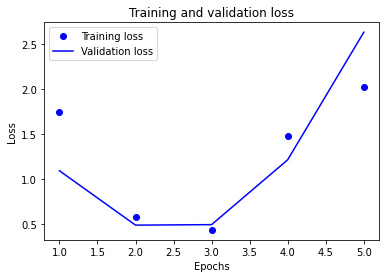

In [122]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

validation loss, training loss가 계속... 오르는 그래프입니다.

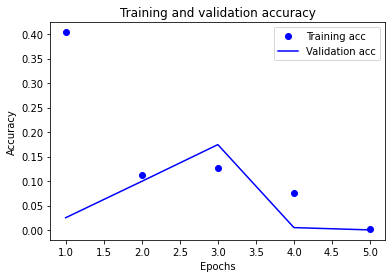

In [123]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training 정확도가 들쑥날쑥하고, validation 정확도도 들쑥날쑥하네요.

# 8. 학습된 Embedding 레이어 분석

In [124]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [125]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [126]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("짜증")

[('용두사미', 0.8448059558868408),
 ('한두', 0.8419141173362732),
 ('서세원', 0.8391510248184204),
 ('어중간', 0.8346887230873108),
 ('한심', 0.8323628902435303),
 ('심한', 0.8317200541496277),
 ('하품', 0.8301092386245728),
 ('작위', 0.8267314434051514),
 ('빙자', 0.8266956806182861),
 ('이따위', 0.8259527683258057)]

In [127]:
word_vectors.similar_by_word("재미")

[('놔서', 0.5616803765296936),
 ('조악', 0.554263710975647),
 ('죽이', 0.5528339743614197),
 ('그지없', 0.5504960417747498),
 ('모티브', 0.5467419028282166),
 ('그지', 0.5436988472938538),
 ('콩', 0.5433833003044128),
 ('징징', 0.5431086421012878),
 ('도중', 0.542404294013977),
 ('허접', 0.5375017523765564)]

In [128]:
word_vectors.similar_by_word("흥미")

[('끌려서', 0.44117769598960876),
 ('아싸', 0.4382929503917694),
 ('통할', 0.4372008144855499),
 ('패션', 0.43634361028671265),
 ('웨폰', 0.43267443776130676),
 ('강력', 0.4235380291938782),
 ('캡', 0.42286598682403564),
 ('해져요', 0.421310156583786),
 ('시원', 0.41990959644317627),
 ('다가왔', 0.4179022014141083)]

# 9. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [142]:
from konlpy.tag import Mecab

- 9번째 파트는 gensim이 제대로 작동하지 않아 못했습니다.
- 다운그레이딩 해서 다운로드 했는데도 잘 안 돼서 원인을 못 찾겠습니다...

관련: https://vg-rlo.tistory.com/44

# 10. 회고

#### 어려웠던 점
- RNN, LSTM, CMM 등의 모델을 사용하여 시도하였지만 LSTM 말고는 제대로 된 acc가 나온 것이 없어 아쉬움
- 모델에 대한 이해도와 프로젝트 흐름을 따라가지 못하니 많은 어려움이 있었음
- 단어간 유사도 찾기까지는 성공적으로 했다고 생각했는데, 성능 평가나 그 뒤로 loss, acc를 볼 때는 들쑥날쑥한 성능이 보였다.
- 마지막 Word2Vec이 되지 않아 다시 해봐야 할 것 같다.

#### 시도와 배운 점
- keras의 많은 모델들을 사용해 보기 위해 tensorflow 가이드에 따라 여러 가지 시도를 해보았다.
- text 전처리 방법은 어느 정도 이해하고 익혔다.

#### 앞으로 해야할 점
- 우수 노드가 나오면 처음부터 끝까지 천천히 비교해보며 볼 필요성이 크게 느껴지는 ex였다.